# 2 Sentiment analysis with LSTM&RNN

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Tue Mar  7 17:24:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
###from google.colab import drive
###drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###import os
###os.chdir('/content/drive/My Drive')

## 2.1 Preparing Data

First set up SEED and classify it into training, test and validation sets.

When preparing the data, note that since RNN can only handle non-populated elements in the sequence (i.e., non-zero data), the output is 0 for any populated elements. so note that when preparing the data, we set include_length to True to get the actual length of the sentences, which we need to use later.

In [ ]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.8/668.8 KB 20.2 MB/s eta 0:00:00
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.3.0-py3-none-any.whl size=12799908 sha256=7826095a08acc1f315d14d3dae67a94432f71252090c1a0bfcfd1746ecb4b102
  Stored in directory: /root/.cache/pip/wheels/59/45/a8/3b4da8b234b490b85991ad56d00ee1df35d26ea29dc542cad4
Successfully built en-core-web-sm
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 893.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


#### Loading IMDB Datasets

#### Select a part of the training set for the validation set

In [ ]:
import random

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))




downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 23.7MB/s]


## 2.2 Word Vector

Next, the initialisation operation is carried out using pre-trained word vectors, where these are obtained by specifying parameters to be passed to build_vocab.

In this case, we choose the GloVe word vector, whose full name is Global Vectors for Word Representation. [here](https://nlp.stanford.edu/projects/glove/) has a detailed description and extensive resources on it. We will not describe exactly how the word vector was obtained, but simply how to use it, here we use "glove.6B.100d", where 6B means that the word vector was trained on 6 billion tokens, and 100d means that the word vector is 100-dimensional (note that the word vector is over 800 megabytes).

Of course, one can also choose [other word vectors](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113). Theoretically, the distance of these pre-trained word vectors in the word embedding vector space characterises to some extent the semantic relationships between words, e.g., "terrible", "awful", " dreadful" , which will be very close to each other in the word embedding vector space.

TEXT.build_vocab indicates that the word vectors of the words in the current training data are extracted from the pre-trained word vectors to form a Vocab (vocabulary) for the current training set. For words that do not occur in the current word vector corpus (noted as UNK, unknown), they are randomly initialised by a Gaussian distribution (unk_init = torch.Tensor.normal_).

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:12<00:00, 32903.56it/s]


## 2.3 Creating iterators + picking GPUs

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
from IPython.display import Image
sen1 = ('/content/drive/My Drive/nlp/sentiment2.png')
sen2 = ('/content/drive/My Drive/nlp/sentiment3.png')
sen3 = ('/content/drive/My Drive/nlp/sentiment4.png')

## 2.4 Building the model


### LSTM

The LSTM is a variant of the standard RNN that adds a way to carry information across multiple time steps, somewhat overcoming the problem of [gradient disappearance](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) that exists with the standard RNN. Specifically, the LSTM incorporates a memory unit $c_t$, which can be thought of as the "memory" of the LSTM, storing the memory of the LSTM at moment $t$, which can be thought of as holding all the necessary information from the past to moment $t$, while using multiple gates to control the flow of information into and out of the memory, see specifically [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).We can therefore think of the LSTM as a function of $x_t$,$h_t$,$c_t$.
$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$
Thus, the model structure using LSTM looks similar to the following construction (omitting the embedding layer).

In [ ]:
Image(sen1)

As with the initial hidden state, the initial memory state $c_0$ is initialized to the full zero tensor. Note that the sentiment prediction uses only the final hidden state, not the final memory cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN


Two-way RNNN adds an RNNN layer processed in the opposite direction to the previous standard RNN layer. Then, the hidden states of the two RNN layers at each moment are spliced together and used as the final hidden state vector. That is, at time step $t$, the forward RNN processes the word $x_t$ and the backward RNN processes the word $x_{T-t+1}$. With such bidirectional processing, the hidden states corresponding to each word can aggregate information from both the left and right directions, and in this way these vectors encode more balanced information.

We use the last hidden state of the forward RNN (obtained from the last word of the sentence) $h_T^\rightarrow$ and the last hidden state of the backward RNN (obtained from the first word of the sentence) $h_T^\leftarrow$ for sentiment prediction, i.e. $\hat{y}=f(h_T^\rightarrow, h_ T^\leftarrow)$, the figure below shows a bidirectional RNN with the forward RNN in orange, the backward RNN in green and the linear layer in silver.

In [ ]:
Image(sen2)

### Multi-layer RNNs

Multi-layer RNNs (also known as deep RNNs): several more layers of RNNs are added to the initial standard RNN. the hidden state output by the first (bottom) RNN at time step $t$ will be the input to the RNN above it at time step $t$, and then predictions are made based on the final hidden state of the final (highest) layer.
The figure below shows a multi-layer one-way RNN, where the layer numbers are given as superscripts. Note also that each layer requires its own initial hidden state, $h_0^L$.

In [ ]:
Image(sen3)

### Regularisation

We have improved the model in various ways, but we need to be aware that as the parameters of the model are gradually increased, the greater the likelihood of overfitting the model. To address this, we add dropout regularisation. dropout works by randomly *Dropout* (set to 0) the neurons in the layer during forward propagation. The probability of whether each neuron is dropped or not is then set by a hyperparameter and is not affected by other neurons.

One theory of why dropout works is that a model with a parameter dropout can be considered a "weaker" (less parameterized) model. Thus, the final model can be thought of as the set of all these weaker models, none of which are over-parameterised, thus reducing the likelihood of overfitting.

### Implementation Details

1. One additional point about the model training process: during the model training process, the model should not be trained on the padding token added to each sample, i.e. it does not learn the embedding of the "\<pad\>" token. This is because the padding token is independent of the sentiment of the sentence. This means that the embedding layer (word vector) of the pad token is always initialised (initialised to all zeros). Specifically, we do this by passing the index index of the pad token to the nn.Embedding layer as the padding_idx parameter.

2. Since the bi-directional LSTM used in the experiment contains both forward and backward propagation processes, the final hidden state vector contains both forward and backward hidden states, so the shape of the input in the next nn.Linear layer is twice the shape of the hidden layer dimension.
    
3. Before feeding the embeddings (word vectors) into the RNN, we need to 'pack' them with `nn.utils.rnn.packed_padded_sequence` to ensure that the RNN will only process tokens that are not pads. The output we get includes `packed_output` (a packed sequence) as well as `hidden sate` and `cell state`. If no 'packing' is done, then the output of `hidden state` and `cell state` is most likely to be the pad token from the sentence. of `hidden state` and `cell state`.

4. We then 'unpack' the output sentences into a tensor tensor with the help of `nn.utils.rnn.pad_packed_sequence`. Note that the output from the padding tokens is a zero tensor, and normally we only need to 'unpack' the output if we are going to use it in a subsequent model. Although this is not necessary in this case, this is just to show the steps.

5. final hidden sate: also known as hidden, its shape is [num layers * num directions, batch size, hid dim]. Because we just need the last forward and backward propagating hidden states, we just need the last 2 hidden layers on the line hidden[-2,:,:] and hidden[-1,:,:], then merge them together and pass them into the linear layer. 
##### I don't know how to interpret this better here, it needs to be adjusted.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # embedding layer(word vector)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # RNN variant - Bidirectional LSTM
        self.rnn = nn.LSTM(embedding_dim,  # input_size
                           hidden_dim,  #output_size
                           num_layers=n_layers,  # Number of layers
                           bidirectional=bidirectional, #whether Bidirectional
                           dropout=dropout) #Random removal of neurons
        # Linear connection layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        # Since the forward propagation + backward propagation has two hidden sate, and is combined, multiply by 2
        
        # Random removal of neurons
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #shape of text [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #shape of embedded [sent len, batch size, emb dim]
        
        # pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #shape ofoutput[sent len, batch size, hid dim * num directions]
        #The padding tokens in the output are tensors with a value of 0
        
        #shape of hidden [num layers * num directions, batch size, hid dim]
        #shape of cell [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #shape of hidden [batch size, hid dim * num directions]
            
        return self.fc(hidden)

## 2.5 Instantiating the model + passing in parameters

To ensure that the pre-trained word vector can be loaded into the model, EMBEDDING_DIM must be equal to the size of the pre-trained GloVe word vector.

In [ ]:
INPUT_DIM = len(TEXT.vocab) 
# 250002: Previously set to take only the 25,000 most frequent words
#plus pad_token and unknown token
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 
#Specify the parameter that defines the index value of the pad_token
#so that the model does not care about the pad token.

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

View the number of model parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


Next, the pre-trained word vectors loaded earlier are copied into the embedding embedding layer in our model, replacing the weight parameters initialised by the original model with the pre-trained embeddings word vectors.

We retrieve the embeddings from the field's vocab and check that they are of the correct size, _**[vocab size, embedding dim]**_

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
# Checking the shape of word vectors [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
# Replace the weight parameters initialized by the original model with the pre-trained embedding word vector
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0370,  0.0438,  0.6341,  ..., -0.1467, -0.3906,  0.7065],
        [-0.4892,  0.0983,  0.1386,  ...,  0.4213, -0.3080,  0.7287],
        [ 0.1738, -0.1278,  0.5066,  ..., -0.3586, -0.4990,  0.6640]])

Because our `<unk>` and `<pad>` tokens are not in the pre-trained word list, they have already been initialised using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our own word list. So it is better to explicitly tell the model to initialise them to 0, they are not relevant to sentiment.
    
We did this by manually setting their word vector weights to 0.
    
**Note**: As with initialising embeddings, this should be done on "weight.data" and not "weight"!

In [ ]:
#Set Unknown and Filler to 0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0370,  0.0438,  0.6341,  ..., -0.1467, -0.3906,  0.7065],
        [-0.4892,  0.0983,  0.1386,  ...,  0.4213, -0.3080,  0.7287],
        [ 0.1738, -0.1278,  0.5066,  ..., -0.3586, -0.4990,  0.6640]])


We can now see that the first two rows of the embedding weight matrix have a value of 0. It is important to note that the word vector of the pad token is never learned during the training of the model. The word vectors of unknown token are learned.

## 2.6 Training the model

Now start training the model!

We are changing the stochastic gradient descent optimizer from 'SGD' to 'Adam'. SGD updates all parameters simultaneously using our set learning rate, while Adam adjusts the learning rate for each parameter, giving parameters that are updated more frequently, as well as parameters that are updated less frequently and parameters that are updated less frequently. For more information on 'Adam' (and other optimisers), see [here](http://ruder.io/optimizing-gradient-descent/index.html).
 
To change 'SGD' to 'Adam', we simply change 'optim.SGD' to 'optim.Adam', and note that we do not provide an initial learning rate for Adam, as PyTorch provides a default initial learning rate.

### 2.6.1 Setting up the optimizer

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

### 2.6.2 Setting up the loss function and GPU

The other steps of training the model remain the same.

In [ ]:
criterion = nn.BCEWithLogitsLoss() 

model = model.to(device)
criterion = criterion.to(device)

### 2.6.3 Calculation accuracy

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

### 2.6.4 Define a training function to train the model

As we set "include_length=True", our "batch.text" is now a tuple, with the first element being the number tensor and the second element being the actual length of each sequence. Before passing them to the model, we split them into their respective variables "text" and "text_length".

**Note**: Since we are now using dropout, we must remember to use `model.train()` to ensure that dropout is turned on during training.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad() # Gradient clearing
        
        text, text_lengths = batch.text 
# batch.text returns a tuple (a tensor of digits, the length of each sentence) 
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        # Gradient cropping to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 2.6.5 Defining a test function

**Note**: Since dropout is now used, we must remember to use `model.eval()` to ensure that dropout is turned off during evaluation.

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text  
#batch.text returns a tuple (a tensor of digits, the length of each sentence)
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

A function can also be created to tell us how long epochs take to train.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 2.6.6 Formal training model

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 0.659 | Train Acc: 60.53%
	 Val. Loss: 0.663 |  Val. Acc: 64.53%
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 0.598 | Train Acc: 67.79%
	 Val. Loss: 0.536 |  Val. Acc: 74.57%
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.509 | Train Acc: 75.50%
	 Val. Loss: 0.407 |  Val. Acc: 82.68%
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.426 | Train Acc: 81.36%
	 Val. Loss: 0.487 |  Val. Acc: 74.37%
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.395 | Train Acc: 82.46%
	 Val. Loss: 0.329 |  Val. Acc: 86.46%


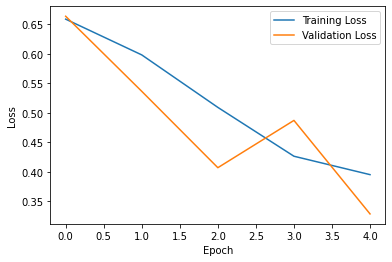

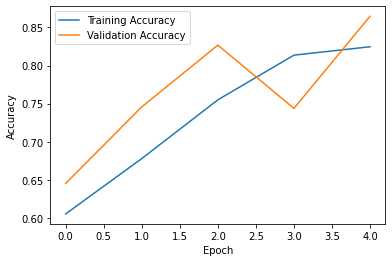

In [ ]:
import matplotlib.pyplot as plt
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # Keep the model parameter with the best training result and load this later for prediction
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2.6.7 Final test results

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.357 | Test Acc: 85.13%


## 2.7 Model validation

We can now use the model to predict the sentiment of any sentences we are given, noting that the sentences that need to be provided are in terms of movie reviews.

When using the model for actual prediction, the model should always be in evaluation mode.
    
The "predict_sentiment" function does the following.

- switch the model to evaluation mode
- Splitting the sentence into words
- converts each word, corresponding to the lexicon, into its corresponding index index.
- get the length of the sentence
- convert the indexes from list to tensor
- add a batch dimension by unsqueezing
- convert length into a tensor
- compress the predictions to between 0 and 1 using the sigmoid function
- Convert a tensor with only one value into an integer using the item() method

Negative comments return a value close to 0, positive comments return a value close to 1.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    # return prediction.item()
    if prediction >= 0.75:
      print(prediction.item(),"This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
      print(prediction.item(),"This sentence represents a weak postive emotion.")
    elif 0.45<= prediction and prediction <= 0.55:
      print(prediction.item(),"This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
      print(prediction.item(),"This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
      print(prediction.item(),"This sentence represents a strong negative emotion.")

Examples of positive comments.

In [ ]:
predict_sentiment(model, "I don't want meet him.")

0.35884156823158264 This sentence represents a weak negative emotion.


Test


In [ ]:
predict_sentiment(model, "All sins are rooted in two major sins, anxiety and laziness.")

0.04425008222460747 This sentence represents a strong negative emotion.


Examples of negative comments.

In [ ]:
predict_sentiment(model,"Dinner is scrumptious!")

0.8715457916259766 This sentence represents a strong positive emotion.


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Set thresholds
threshold = 0.5

# Disable gradient calculation
with torch.no_grad():
    model.eval()
    y_true = []
    y_pred = []

    for batch in test_iterator:
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        # Convert output values to categories
        preds = torch.sigmoid(predictions) > threshold
        y_pred.extend(preds.tolist())
        y_true.extend(batch.label.tolist())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)
# Normalised confusion matrix
cm_norm = normalize(cm, axis=1, norm='l1')
print(cm_norm)

[[10329  2171]
 [ 1541 10959]]
[[0.82632 0.17368]
 [0.12328 0.87672]]


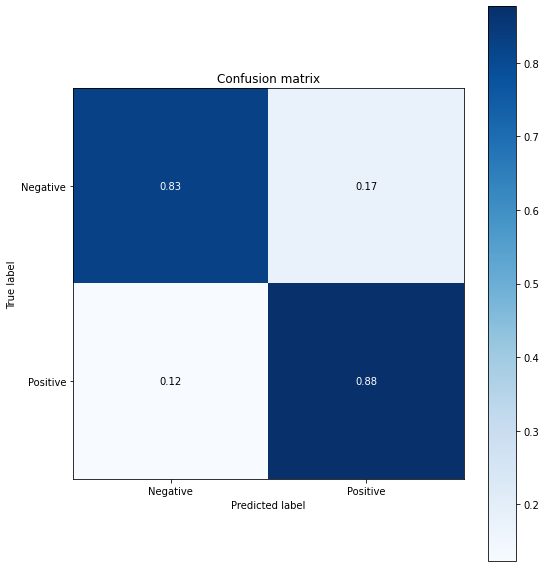

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up tags
labels = ['Negative', 'Positive']

# Draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add a comment
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculation of assessment indicators
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = recall

print(f"Confusion Matrix:\n{cm_norm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

Confusion Matrix:
[[0.82632 0.17368]
 [0.12328 0.87672]]
Accuracy: 0.8515
Precision: 0.8347
Recall: 0.8767
Specificity: 0.8263
Sensitivity: 0.8767


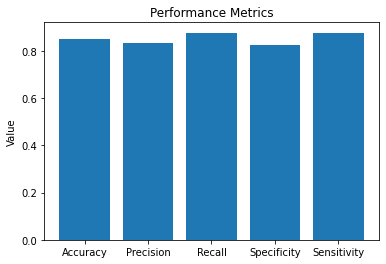

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the assessment indicators from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
sensitivity = recall

# Putting indicators into arrays for plotting
ind = np.arange(5)
vals = [accuracy, precision, recall, specificity, sensitivity]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'Sensitivity']

# Plotting bar charts
plt.bar(ind, vals)
plt.xticks(ind, labels)
plt.ylabel('Value')
plt.title('Performance Metrics')
plt.show()
